In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.optimizers import Adam

img_height, img_width = 300, 300


# Custom focal loss definition (if used in the model)
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        pt = tf.exp(-bce)
        return alpha * (1 - pt) ** gamma * bce

    return loss


# Load the trained model
model = load_model(
    "./Custom Model/section_2_clear.h5", custom_objects={"loss": focal_loss()}
)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=focal_loss(),
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
)


def predict_single_image(image_path, model):
    try:
        # Load and preprocess the image
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Image not found or cannot be loaded: {image_path}")

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        img = cv2.resize(img, (img_height, img_width))  # Resize to model input size
        img = img / 255.0  # Normalize pixel values to [0, 1]
        img = tf.expand_dims(img, axis=0)  # Add batch dimension

        # Predict using the loaded model
        prediction = model.predict(img, verbose=0)  # Suppress verbose output
        predicted_class = (prediction > 0.5).astype(int)  # Binary class prediction
        probability = prediction[0][0]

        print(f"Predicted Class: {predicted_class[0]}, Probability: {probability:.2f}")
        return predicted_class[0], probability
    except Exception as e:
        print(f"Error in prediction: {e}")
        return None, None


# Example usage
predict_single_image("./Clear Section 2/train/class 0/bad_m_275.png", model)

Predicted Class: [1], Probability: 1.00


(array([1]), 1.0)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Paths to the images
master_image_path = "./clear_section.png"
captured_image_path = "./Analog_mobile/test/class 0/bad_m_46.png"

# Load images in grayscale
master_image = cv2.imread(master_image_path, cv2.IMREAD_GRAYSCALE)
captured_image = cv2.imread(captured_image_path, cv2.IMREAD_GRAYSCALE)

# Resize captured image to match master image dimensions
captured_image = cv2.resize(
    captured_image, (master_image.shape[1], master_image.shape[0])
)

# --- Step 1: Adaptive Thresholding for Consistent Segmentation ---
master_thresh = cv2.adaptiveThreshold(
    master_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
)
captured_thresh = cv2.adaptiveThreshold(
    captured_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
)

# --- Step 2: Find Contours ---
master_contours, _ = cv2.findContours(
    master_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)
captured_contours, _ = cv2.findContours(
    captured_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

# --- Step 3: Compare Contours ---
missing_segments = []

for master_contour in master_contours:
    match_found = False

    # Only consider contours of similar area
    master_area = cv2.contourArea(master_contour)

    for captured_contour in captured_contours:
        captured_area = cv2.contourArea(captured_contour)

        # Check for approximate area match (within a tolerance range)
        if abs(master_area - captured_area) < 500:  # Adjust tolerance as needed
            # Compare contour shapes using matchShapes
            shape_diff = cv2.matchShapes(
                master_contour, captured_contour, cv2.CONTOURS_MATCH_I1, 0.0
            )
            if shape_diff < 0.05:  # Threshold for shape similarity, adjust as needed
                match_found = True
                break

    if not match_found:
        missing_segments.append(master_contour)

# --- Step 4: Highlight Missing Segments ---
output_image = cv2.cvtColor(master_image, cv2.COLOR_GRAY2BGR)
for segment in missing_segments:
    cv2.drawContours(output_image, [segment], -1, (0, 0, 255), 2)  # Highlight in red

# --- Step 5: Visualize Results ---
plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.title("Master Image (Thresholded)")
plt.imshow(master_thresh, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Captured Image (Thresholded)")
plt.imshow(captured_thresh, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Missing Segments Highlighted")
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()

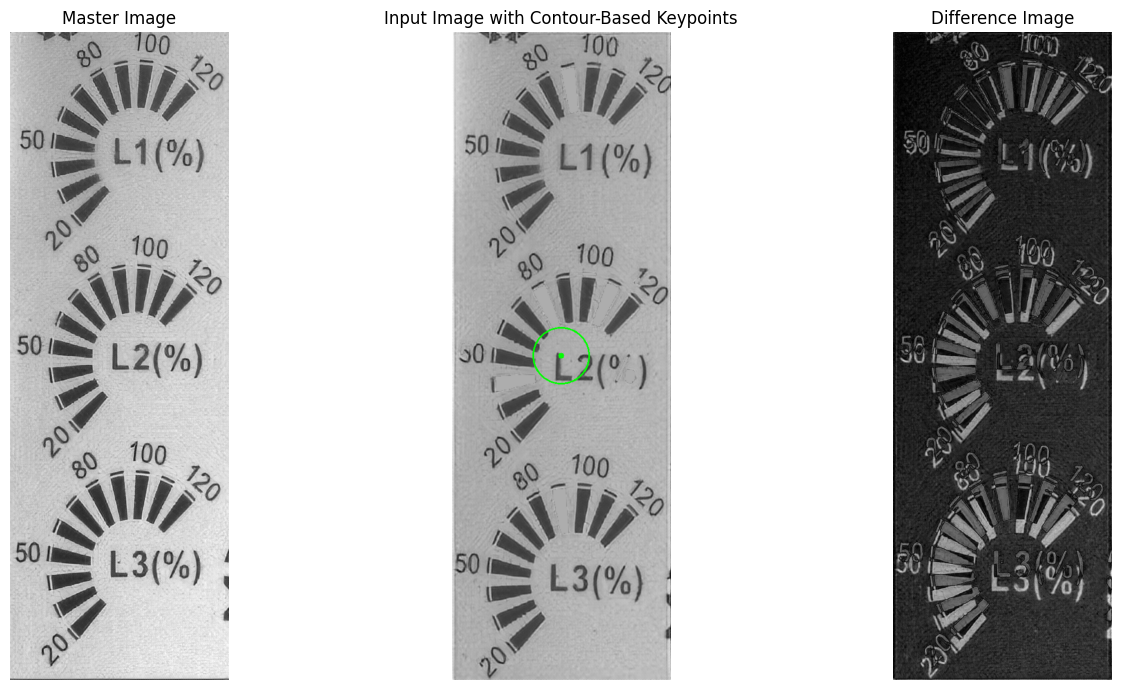

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Paths to the images
master_image_path = "./clear_section.png"
input_image_path = "./Analog_mobile/test/class 0/bad_m_46.png"

# Load images
master_image = cv2.imread(master_image_path, cv2.IMREAD_GRAYSCALE)
input_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)

# Resize input image to match master image dimensions
input_image = cv2.resize(input_image, (master_image.shape[1], master_image.shape[0]))


# Function to extract contour centroids
def get_contour_centroids(image, threshold=50):
    # Threshold the image to get binary
    _, binary = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    # Detect contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Calculate centroids of contours
    centroids = []
    for contour in contours:
        if cv2.contourArea(contour) < 10:  # Filter out small contours
            continue
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            centroids.append((cx, cy))
    return centroids


# Extract centroids from master and input images
master_centroids = get_contour_centroids(master_image)
input_centroids = get_contour_centroids(input_image)

# Match centroids based on distance
radius = 50  # Define the matching radius
matched = []
unmatched = input_centroids.copy()

for input_pt in input_centroids:
    for master_pt in master_centroids:
        distance = np.linalg.norm(np.array(input_pt) - np.array(master_pt))
        if distance <= radius:
            matched.append(input_pt)
            if input_pt in unmatched:
                unmatched.remove(input_pt)
            break

# Create output image
output_image = cv2.cvtColor(input_image, cv2.COLOR_GRAY2BGR)

# Mark matched centroids in green
for pt in matched:
    cv2.circle(output_image, pt, radius, (0, 255, 0), 2)  # Green circle
    cv2.circle(output_image, pt, 5, (0, 255, 0), -1)  # Green center

# Mark unmatched centroids in red
for pt in unmatched:
    cv2.circle(output_image, pt, radius, (0, 0, 255), 2)  # Red circle
    cv2.circle(output_image, pt, 5, (0, 0, 255), -1)  # Red center

# Display results
plt.figure(figsize=(15, 7))
plt.subplot(1, 3, 1)
plt.title("Master Image")
plt.imshow(master_image, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Input Image with Contour-Based Keypoints")
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis("off")

# Optional: Display differences
difference_image = cv2.absdiff(master_image, input_image)
plt.subplot(1, 3, 3)
plt.title("Difference Image")
plt.imshow(difference_image, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import cv2
import numpy as np


# Function to dynamically select the threshold value
def select_threshold(image):
    def update_threshold(val):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Use the morphed image for thresholding and contour detection
        _, binary = cv2.threshold(gray, val, 255, cv2.THRESH_BINARY_INV)
        contours, _ = cv2.findContours(
            binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
        contour_image = image.copy()
        for contour in contours:
            if cv2.contourArea(contour) > 10:
                cv2.drawContours(contour_image, [contour], -1, (0, 255, 0), 2)
        cv2.imshow("Select Threshold", contour_image)

    cv2.namedWindow("Select Threshold", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Select Threshold", 500, 800)
    cv2.createTrackbar("Threshold", "Select Threshold", 128, 255, update_threshold)
    update_threshold(128)
    cv2.waitKey(0)
    threshold_value = cv2.getTrackbarPos("Threshold", "Select Threshold")
    cv2.destroyAllWindows()
    return threshold_value


# Function to interactively select contours based on mouse clicks
def select_contours(image, contours):
    selected_contours = []

    def on_mouse_click(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            for contour in contours:
                if (
                    cv2.pointPolygonTest(contour, (x, y), False) >= 0
                ):  # Check if point is inside contour
                    selected_contours.append(contour)
                    # Draw the contour to indicate selection
                    cv2.drawContours(image, [contour], -1, (0, 255, 0), 2)
                    print("Contour selected!")
            cv2.imshow("Select Contours", image)

    # Show the image and wait for user input
    cv2.imshow("Select Contours", image)
    cv2.setMouseCallback("Select Contours", on_mouse_click)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return selected_contours


# Function to filter keypoints inside selected contours
def filter_keypoints_by_contours(keypoints, selected_contours):
    filtered_keypoints = []
    for kp in keypoints:
        x, y = kp.pt
        for contour in selected_contours:
            if (
                cv2.pointPolygonTest(contour, (x, y), False) >= 0
            ):  # Keypoint inside the contour
                filtered_keypoints.append(kp)
    return filtered_keypoints


# Load the image
image_path = "./clear_section.png"
image = cv2.imread(image_path)

# Select the threshold value dynamically
threshold_value = select_threshold(image)

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Use the morphed image for thresholding and contour detection
_, binary = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY_INV)
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the detected contours on the original image
contour_image = image.copy()
for contour in contours:
    if cv2.contourArea(contour) > 10:  # Filter out small contours
        cv2.drawContours(contour_image, [contour], -1, (0, 255, 0), 2)

# Select contours interactively from the image
selected_contours = [contour for contour in contours if cv2.contourArea(contour) > 10]
# Now detect keypoints using ORB
orb = cv2.ORB_create()
keypoints, descriptors = orb.detectAndCompute(image, None)

# Filter keypoints based on the selected contours
filtered_keypoints = filter_keypoints_by_contours(keypoints, selected_contours)

# Draw the filtered keypoints on the image
image_with_keypoints = image.copy()
cv2.drawKeypoints(
    image_with_keypoints,
    filtered_keypoints,
    image_with_keypoints,
    color=(0, 0, 255),
    flags=0,
)

# Show the result with selected contours and keypoints
cv2.imshow("Selected Keypoints", image_with_keypoints)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Optionally, save the keypoints and descriptors inside the selected contours
filtered_descriptors = [
    descriptors[i] for i, kp in enumerate(keypoints) if kp in filtered_keypoints
]


print(f"Number of selected keypoints: {len(filtered_keypoints)}")

Number of selected keypoints: 447


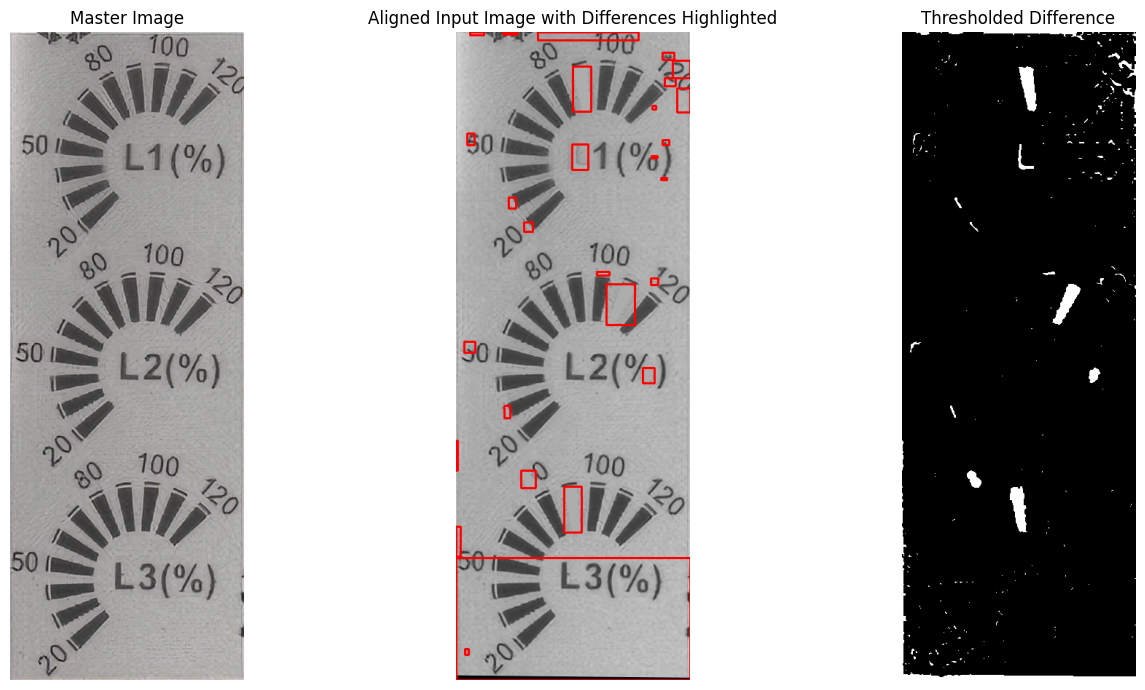

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


# Function to preprocess images (e.g., denoise, adjust contrast)
def preprocess_image(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Apply histogram equalization to improve contrast
    equalized = cv2.equalizeHist(blurred)

    return equalized


# Function to align the input image to the master image
def align_images(master, input_img):
    master_preprocessed = preprocess_image(master)
    input_preprocessed = preprocess_image(input_img)

    # Detect and describe features using ORB
    orb = cv2.ORB_create()
    keypoints1, descriptors1 = orb.detectAndCompute(master_preprocessed, None)
    keypoints2, descriptors2 = orb.detectAndCompute(input_preprocessed, None)

    # Match features using BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)

    # Extract matched points
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Compute the homography matrix
    h_matrix, _ = cv2.findHomography(points2, points1, cv2.RANSAC, 5.0)

    # Align the input image
    aligned_img = cv2.warpPerspective(
        input_img, h_matrix, (master.shape[1], master.shape[0])
    )
    return aligned_img


# Load images
master_image_path = "./Analog_mobile/test/class 1/good_243.png"
input_image_path = "./Analog_mobile/test/class 0/bad_m_88.png"

master_image = cv2.imread(master_image_path)
input_image = cv2.imread(input_image_path)

input_image = cv2.resize(input_image, (master_image.shape[1], master_image.shape[0]))

# Align the input image to the master image
aligned_input_img = align_images(master_image, input_image)

# Preprocess both images for comparison
aligned_master_gray = preprocess_image(master_image)
aligned_input_gray = preprocess_image(aligned_input_img)

# Compute the absolute difference
difference = cv2.absdiff(aligned_master_gray, aligned_input_gray)

cv2.imwrite("difference.png", difference)

_, thresholded_diff = cv2.threshold(
    difference, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

# Optional: Morphological operation to clean small noise
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
thresholded_diff = cv2.morphologyEx(thresholded_diff, cv2.MORPH_CLOSE, kernel)

# Find contours of differences
contours, _ = cv2.findContours(
    thresholded_diff, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

# Highlight differences on the aligned input image
highlighted_image = aligned_input_img.copy()
for contour in contours:
    if (
        cv2.contourArea(contour) > 10 and cv2.contourArea(contour) < 2000
    ):  # Filter small differences
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(highlighted_image, (x, y), (x + w, y + h), (0, 0, 255), 2)

# Display results
plt.figure(figsize=(15, 7))
plt.subplot(1, 3, 1)
plt.title("Master Image")
plt.imshow(cv2.cvtColor(master_image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Aligned Input Image with Differences Highlighted")
plt.imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Thresholded Difference")
plt.imshow(thresholded_diff, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

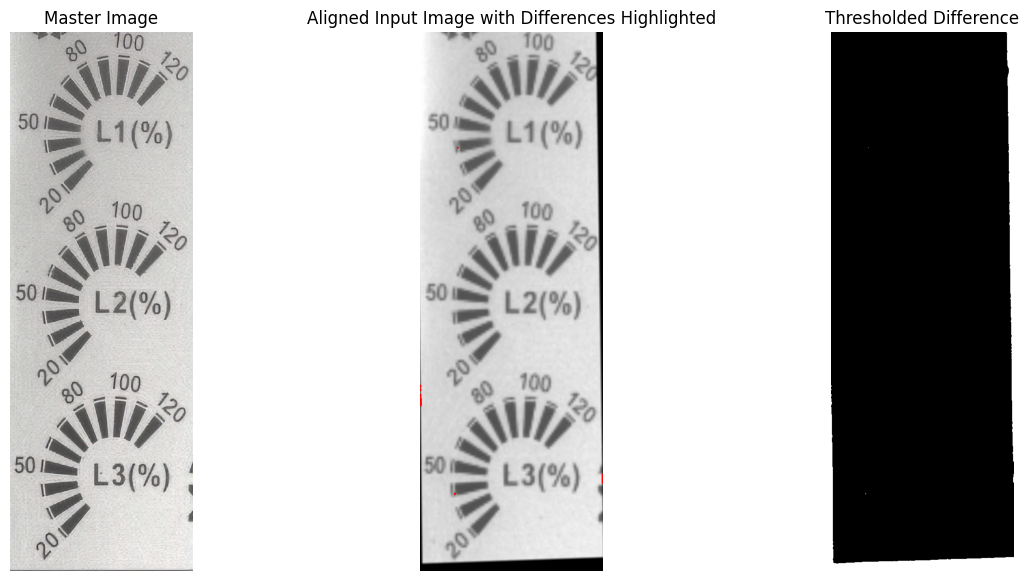

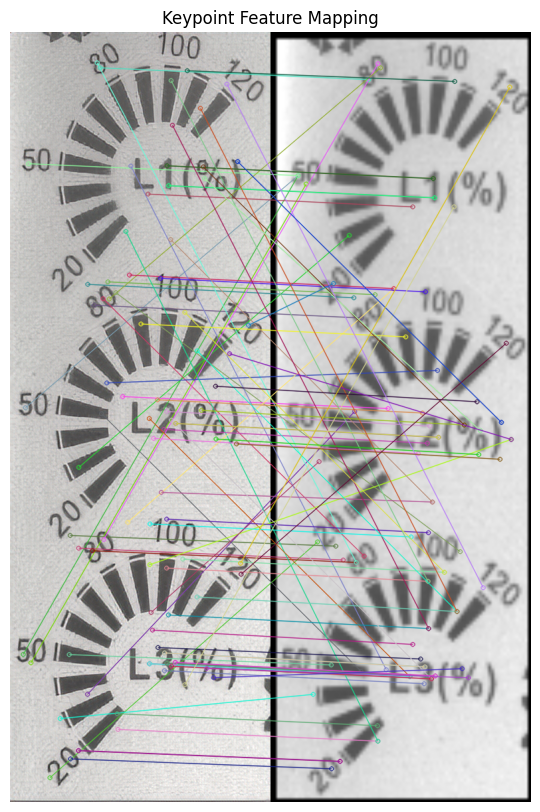

<Figure size 640x480 with 0 Axes>

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


# Function to preprocess images
def preprocess_image(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to improve local contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(blurred)
    return equalized


# Function to align the input image to the master image
def align_images(master, input_img):
    # Preprocess both images
    master_preprocessed = preprocess_image(master)
    input_preprocessed = preprocess_image(input_img)

    # Use SIFT for feature detection and description
    sift = cv2.SIFT_create(nfeatures=5000)  # Increased number of features
    keypoints1, descriptors1 = sift.detectAndCompute(master_preprocessed, None)
    keypoints2, descriptors2 = sift.detectAndCompute(input_preprocessed, None)

    # Match features using FLANN-based matcher
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # Apply Lowe's ratio test to filter good matches
    good_matches = [m for m, n in matches if m.distance < 0.6 * n.distance]

    # Ensure we have enough matches to compute homography
    if len(good_matches) < 4:
        raise ValueError(
            "Not enough matches found to compute homography. Alignment failed."
        )

    # Extract matched points
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(
        -1, 1, 2
    )
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(
        -1, 1, 2
    )

    # Compute the homography matrix
    h_matrix, mask = cv2.findHomography(points2, points1, cv2.RANSAC, 5.0)

    # Align the input image
    aligned_img = cv2.warpPerspective(
        input_img, h_matrix, (master.shape[1], master.shape[0])
    )
    matched_image = cv2.drawMatches(
        master,
        keypoints1,
        input_img,
        keypoints2,
        good_matches,
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    )
    return aligned_img, h_matrix, matched_image


# Load images
master_image_path = "./clear_section.png"
input_image_path = "./Analog/test/class 1/good_4.png"

master_image = cv2.imread(master_image_path)
input_image = cv2.imread(input_image_path)

# Resize input image to match the size of the master image
input_image = cv2.resize(input_image, (master_image.shape[1], master_image.shape[0]))

# Align the input image to the master image
aligned_input_img, h_matrix, matched_image = align_images(master_image, input_image)

# Preprocess both images for comparison
aligned_master_gray = preprocess_image(master_image)
aligned_input_gray = preprocess_image(aligned_input_img)

# Compute the absolute difference
difference = cv2.absdiff(aligned_master_gray, aligned_input_gray)

# Save the difference image
cv2.imwrite("difference.png", difference)

# Threshold the difference image
_, thresholded_diff = cv2.threshold(
    difference, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

# Apply morphological operations to remove small noise
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
thresholded_diff = cv2.morphologyEx(thresholded_diff, cv2.MORPH_CLOSE, kernel)

# Find contours of differences
contours, _ = cv2.findContours(
    thresholded_diff, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

# Highlight differences on the aligned input image
highlighted_image = aligned_input_img.copy()
for contour in contours:
    if (
        cv2.contourArea(contour) < 2000
    ):  # Filter small and excessively large differences
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(highlighted_image, (x, y), (x + w, y + h), (0, 0, 255), 2)

# Display results
plt.figure(figsize=(15, 7))
plt.subplot(1, 3, 1)
plt.title("Master Image")
plt.imshow(cv2.cvtColor(master_image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Aligned Input Image with Differences Highlighted")
plt.imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Thresholded Difference")
plt.imshow(thresholded_diff, cmap="gray")
plt.axis("off")

plt.figure(figsize=(20, 10))
plt.title("Keypoint Feature Mapping")
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

plt.tight_layout()
plt.show()

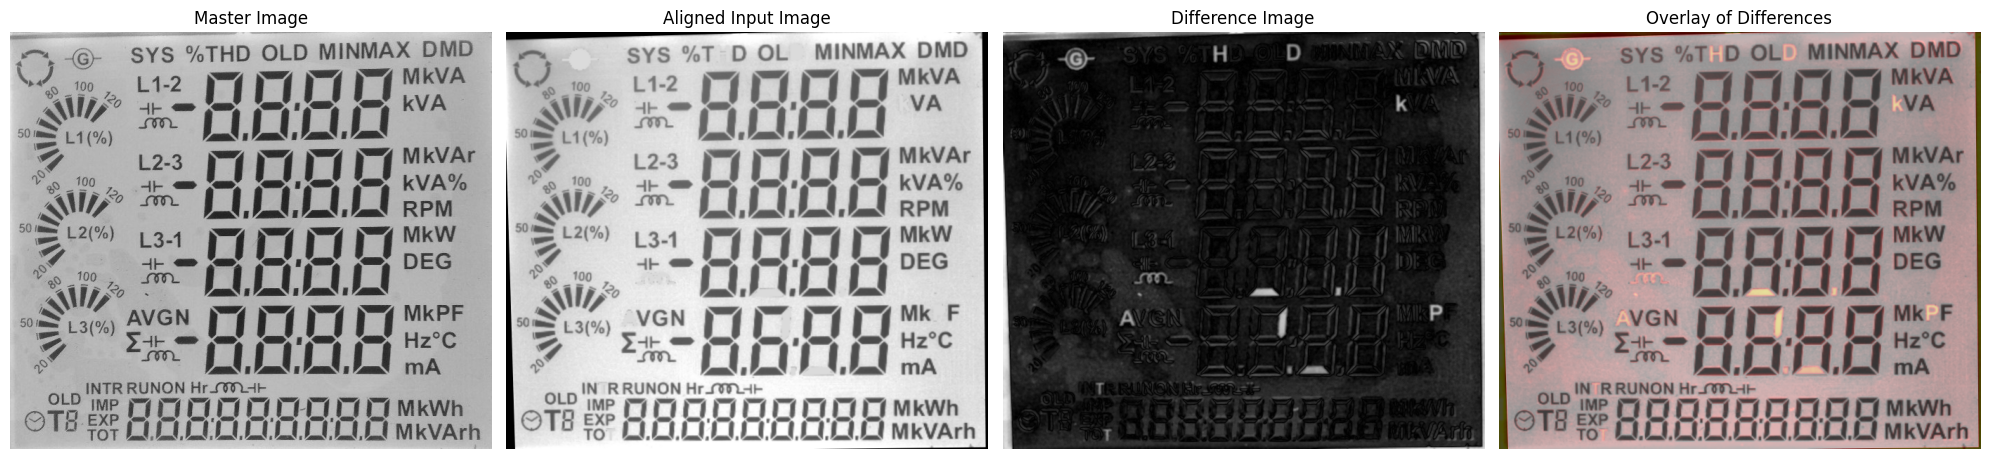

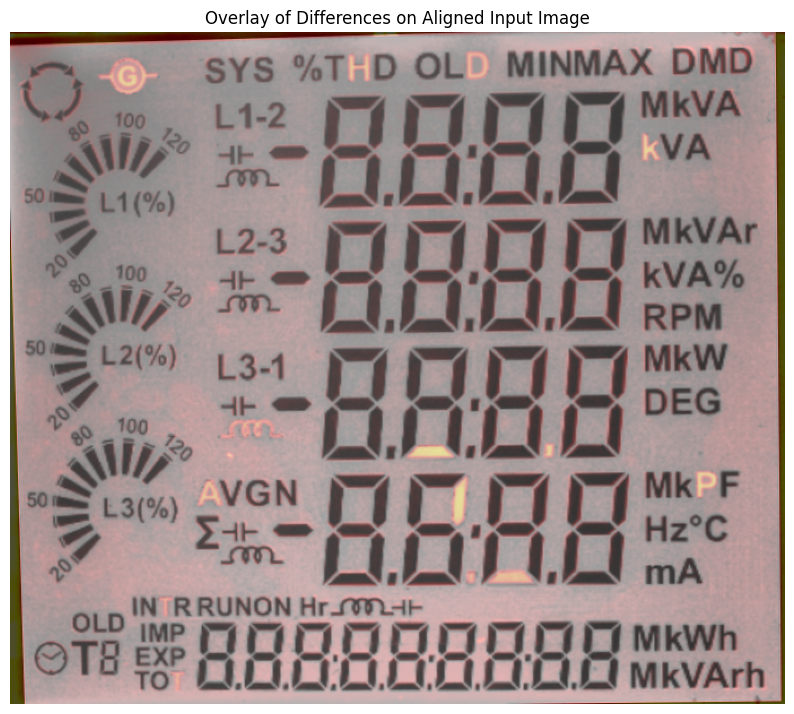

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


# Function to preprocess images
def preprocess_image(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to improve local contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(blurred)
    return equalized


# Function to align the input image to the master image
def align_images(master, input_img):
    # Preprocess both images
    master_preprocessed = preprocess_image(master)
    input_preprocessed = preprocess_image(input_img)

    # Use SIFT for feature detection and description
    sift = cv2.SIFT_create(nfeatures=5000)  # Increased number of features
    keypoints1, descriptors1 = sift.detectAndCompute(master_preprocessed, None)
    keypoints2, descriptors2 = sift.detectAndCompute(input_preprocessed, None)

    # Match features using FLANN-based matcher
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # Apply Lowe's ratio test to filter good matches
    good_matches = [m for m, n in matches if m.distance < 0.6 * n.distance]

    # Ensure we have enough matches to compute homography
    if len(good_matches) < 4:
        raise ValueError(
            "Not enough matches found to compute homography. Alignment failed."
        )

    # Extract matched points
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(
        -1, 1, 2
    )
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(
        -1, 1, 2
    )

    # Compute the homography matrix
    h_matrix, mask = cv2.findHomography(points2, points1, cv2.RANSAC, 5.0)

    # Align the input image
    aligned_img = cv2.warpPerspective(
        input_img, h_matrix, (master.shape[1], master.shape[0])
    )
    return aligned_img, h_matrix


# Load images
master_image_path = "./Meter.jpg"
input_image_path = "./Digit extraction/full_1.png"

master_image = cv2.imread(master_image_path)
input_image = cv2.imread(input_image_path)

# Resize input image to match the size of the master image
input_image = cv2.resize(input_image, (master_image.shape[1], master_image.shape[0]))

# Align the input image to the master image
aligned_input_img, h_matrix = align_images(master_image, input_image)

# Preprocess both images for comparison
aligned_master_gray = preprocess_image(master_image)
aligned_input_gray = preprocess_image(aligned_input_img)

# Compute the absolute difference
difference = cv2.absdiff(aligned_master_gray, aligned_input_gray)

# Save the difference image
cv2.imwrite("difference.png", difference)

# Threshold the difference image
_, thresholded_diff = cv2.threshold(
    difference, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

# Apply morphological operations to remove small noise
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
thresholded_diff = cv2.morphologyEx(thresholded_diff, cv2.MORPH_CLOSE, kernel)

# Find contours of differences
contours, _ = cv2.findContours(
    thresholded_diff, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

# Highlight differences on the aligned input image
highlighted_image = aligned_input_img.copy()
for contour in contours:
    if (
        cv2.contourArea(contour) < 2000
    ):  # Filter small and excessively large differences
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(highlighted_image, (x, y), (x + w, y + h), (0, 0, 255), 2)

# Normalize the difference image for better visualization
normalized_diff = cv2.normalize(difference, None, 0, 255, cv2.NORM_MINMAX)

# Convert the normalized difference image to a color image using a bright colormap
colored_diff = cv2.applyColorMap(normalized_diff, cv2.COLORMAP_HOT)

# Overlay the colored difference image on the aligned input image
overlay = cv2.addWeighted(aligned_input_img, 0.7, colored_diff, 0.3, 0)

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 4, 1)
plt.title("Master Image")
plt.imshow(cv2.cvtColor(master_image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 4, 2)
plt.title("Aligned Input Image")
plt.imshow(cv2.cvtColor(aligned_input_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 4, 3)
plt.title("Difference Image")
plt.imshow(difference, cmap="gray")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.title("Overlay of Differences")
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()

# Display highlighted differences
plt.figure(figsize=(10, 10))
plt.title("Overlay of Differences on Aligned Input Image")
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

## New Version Canny Edge Detection


SSIM: 0.8775
MSE: 84.0083
Keypoint Reprojection Error: 9.8328
Defects Detected: True


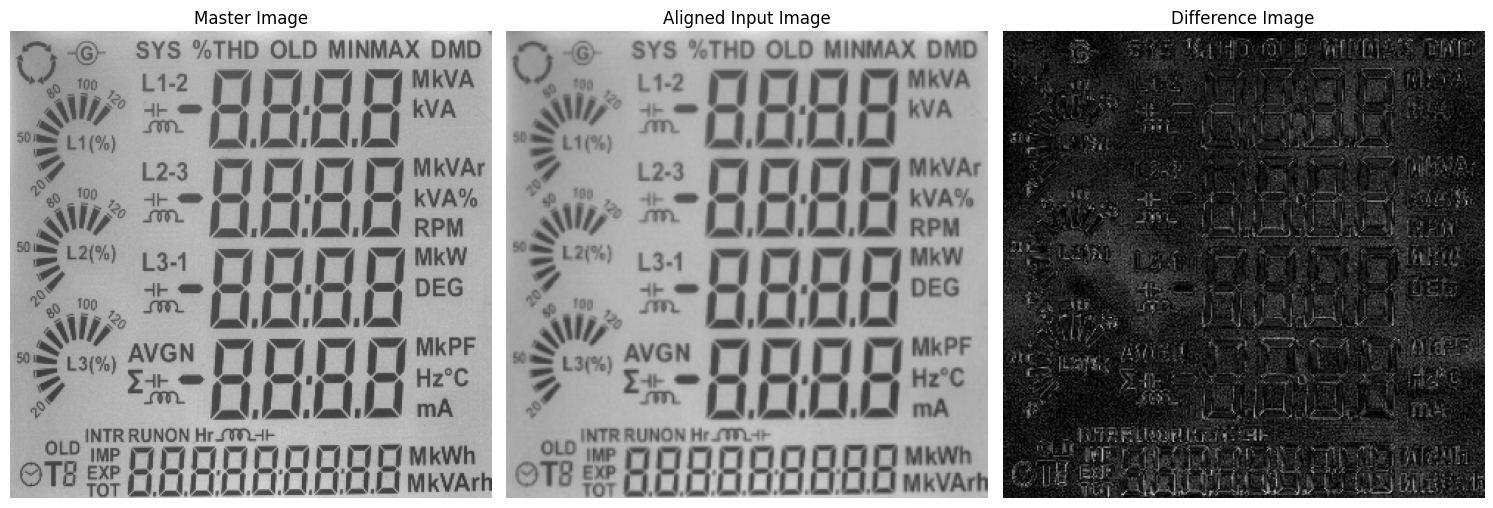

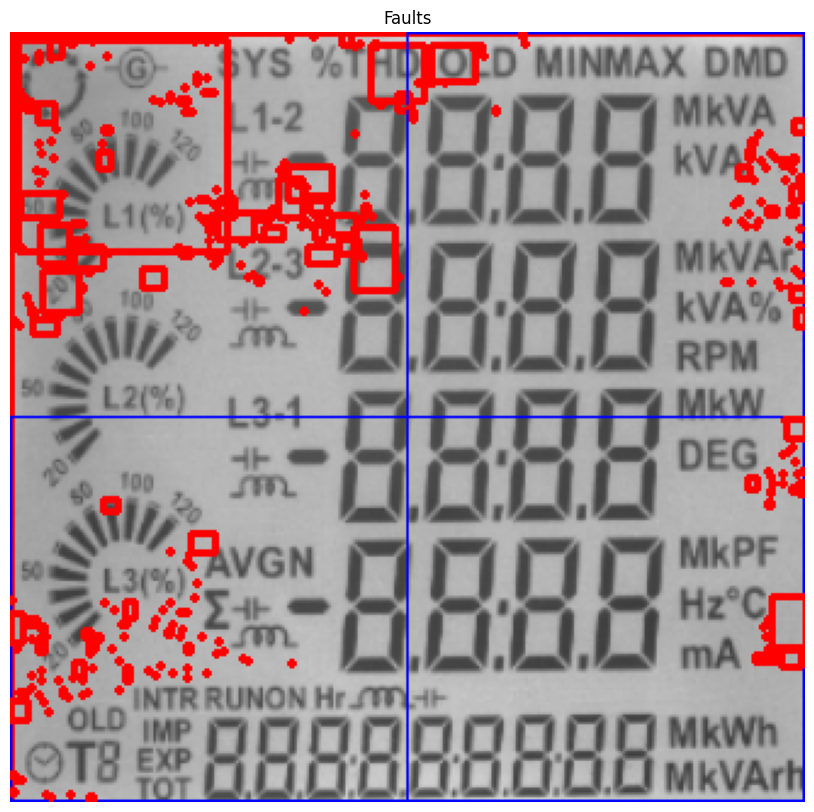

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.metrics import structural_similarity as compare_ssim

# Function to preprocess images (e.g., denoise, adjust contrast)
def preprocess_image(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(gray)
    return equalized

# Function to align the input image to the master image
def align_images(master, input_img):
    master_preprocessed = preprocess_image(master)
    input_preprocessed = preprocess_image(input_img)
    
    # Detect and describe features using SIFT
    sift = cv2.SIFT_create(nfeatures=8000)
    keypoints1, descriptors1 = sift.detectAndCompute(master_preprocessed, None)
    keypoints2, descriptors2 = sift.detectAndCompute(input_preprocessed, None)
    
    # Match features using FLANN-based matcher
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    
    # Apply Lowe's ratio test to filter good matches
    good_matches = [m for m, n in matches if m.distance < 0.5 * n.distance]
    
    # Ensure we have enough matches to compute homography
    if len(good_matches) < 4:
        raise ValueError("Not enough matches found to compute homography. Alignment failed.")
    
    # Extract matched points
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    # Compute the homography matrix
    h_matrix, _ = cv2.findHomography(points2, points1, cv2.RANSAC, 5.0)
    
    # Align the input image
    aligned_img = cv2.warpPerspective(input_img, h_matrix, (master.shape[1], master.shape[0]))
    matched_image = cv2.drawMatches(master, keypoints1, input_img, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return aligned_img, h_matrix, points1, points2, matched_image

# Function to compute alignment metrics
def compute_alignment_metrics(master, aligned_input, h_matrix, points1, points2):
    # Compute SSIM
    ssim_score, _ = compare_ssim(master, aligned_input, full=True)
    
    # Compute MSE
    mse = np.mean((master - aligned_input) ** 2)
    
    # Compute Keypoint Reprojection Error
    points2_transformed = cv2.perspectiveTransform(points2, h_matrix)
    reprojection_error = np.mean(np.linalg.norm(points2_transformed - points1, axis=2))
    
    return ssim_score, mse, reprojection_error

# Function to check for defects in grid sections and draw grid
def check_defects_in_grid(image, contours, grid_size=(8 ,8)):
    height, width = image.shape[:2]
    grid_h, grid_w = grid_size
    section_h = height // grid_h
    section_w = width // grid_w
    
    defect_detected = False
    
    for i in range(grid_h * grid_w):
        x_start = (i % grid_w) * section_w
        y_start = (i // grid_w) * section_h
        x_end = x_start + section_w
        y_end = y_start + section_h
        
        # Draw grid
        cv2.rectangle(image, (x_start, y_start), (x_end, y_end), (255, 0, 0), 1)
        
        # Check for contours in the current section
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if x_start <= x < x_end and y_start <= y < y_end:
                cv2.rectangle(image, (x, y), (x + w, y + h), (0,0,255), 2)
                defect_detected = True
    return defect_detected

# Load images
master_image_path = "./section 2 clear/current_master.png"
input_image_path = "./section 2 clear/section_image_0.png"

master_image = cv2.imread(master_image_path)
input_image = cv2.imread(input_image_path)

# Resize input image to match the size of the master image
input_image = cv2.resize(input_image, (master_image.shape[1], master_image.shape[0]))

# Align the input image to the master image
aligned_input_img, h_matrix, points1, points2, matched_image = align_images(master_image, input_image)

# Preprocess both images for comparison
aligned_master_gray = preprocess_image(master_image)
aligned_input_gray = preprocess_image(aligned_input_img)

# Compute alignment metrics
ssim_score, mse, reprojection_error = compute_alignment_metrics(aligned_master_gray, aligned_input_gray, h_matrix, points1, points2)

# Print alignment metrics
print(f"SSIM: {ssim_score:.4f}")
print(f"MSE: {mse:.4f}")
print(f"Keypoint Reprojection Error: {reprojection_error:.4f}")

# Compute the absolute difference
difference = cv2.absdiff(aligned_master_gray, aligned_input_gray)

# Save the difference image
cv2.imwrite('difference.png', difference)

# Apply Otsu's thresholding to the difference image
thresholded_diff = cv2.threshold(difference, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# Apply morphological operations to remove small noise
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
thresholded_diff = cv2.morphologyEx(thresholded_diff, cv2.MORPH_CLOSE, kernel)

cv2.imwrite("Thresholded Diff.png", thresholded_diff)

# Find contours of differences
contours, _ = cv2.findContours(thresholded_diff, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Highlight differences on the aligned input image and draw grid
highlighted_image = aligned_input_img.copy()
defects_detected = check_defects_in_grid(highlighted_image, contours, grid_size=(2,2))
print(f"Defects Detected: {defects_detected}")

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 4, 1)
plt.title("Master Image")
plt.imshow(cv2.cvtColor(master_image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 4, 2)
plt.title("Aligned Input Image")
plt.imshow(cv2.cvtColor(aligned_input_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 4, 3)
plt.title("Difference Image")
plt.imshow(difference, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 10))
plt.title("Faults")
plt.imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [7]:
from pyueye import ueye
import numpy as np
import cv2
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as compare_ssim


# Define the desired width and height for the live video preview
desired_width = 470  # Set the desired width here
desired_height = 420  # Set the desired height here

# Define the directory to save captured images
save_directory = "./section 2 clear"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Define the predefined sections (rectangles) to capture
# Each tuple represents (x_start, y_start, x_end, y_end)
predefined_sections = [(45, 9, 457, 408)]

def preprocess_image(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray


def align_images(master, input_img):
    # Preprocess both images
    master_preprocessed = preprocess_image(master)
    input_preprocessed = preprocess_image(input_img)

    # Use SIFT for feature detection and description
    sift = cv2.SIFT_create(nfeatures=8000)  # Increased number of features
    keypoints1, descriptors1 = sift.detectAndCompute(master_preprocessed, None)
    keypoints2, descriptors2 = sift.detectAndCompute(input_preprocessed, None)

    # Match features using FLANN-based matcher
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # Apply Lowe's ratio test to filter good matches
    good_matches = [m for m, n in matches if m.distance < 0.5 * n.distance]

    # Ensure we have enough matches to compute homography
    if len(good_matches) < 4:
        raise ValueError(
            "Not enough matches found to compute homography. Alignment failed."
        )

    # Extract matched points
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(
        -1, 1, 2
    )
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(
        -1, 1, 2
    )

    # Compute the homography matrix
    h_matrix, mask = cv2.findHomography(points2, points1, cv2.RANSAC, 5.0)

    # Align the input image
    aligned_img = cv2.warpPerspective(
        input_img, h_matrix, (master.shape[1], master.shape[0])
    )
    return aligned_img, h_matrix,points1,points2

def compute_alignment_metrics(master, aligned_input, h_matrix, points1, points2):
    # Compute SSIM
    ssim_score, _ = compare_ssim(master, aligned_input, full=True)
    
    # Compute MSE
    mse = np.mean((master - aligned_input) ** 2)
    
    # Compute Keypoint Reprojection Error
    points2_transformed = cv2.perspectiveTransform(points2, h_matrix)
    reprojection_error = np.mean(np.linalg.norm(points2_transformed - points1, axis=2))
    
    return ssim_score, mse, reprojection_error


master_image_path = "./section 2 clear/New_Master.png"
input_image_path = "./Digit extraction/fault_1.png"

master_image = cv2.imread(master_image_path)
input_image = cv2.imread(input_image_path)

# Resize input image to match the size of the master image
input_image = cv2.resize(
    input_image, (master_image.shape[1], master_image.shape[0])
)

# Align the input image to the master image
aligned_input_img, h_matrix,points1,points2 = align_images(master_image, input_image)

# Preprocess both images for comparison
aligned_master_gray = preprocess_image(master_image)
aligned_input_gray = preprocess_image(aligned_input_img)

# Compute alignment metrics
ssim_score, mse, reprojection_error = compute_alignment_metrics(aligned_master_gray, aligned_input_gray, h_matrix, points1, points2)

# Print alignment metrics
print(f"SSIM: {ssim_score:.4f}")
print(f"MSE: {mse:.4f}")
print(f"Keypoint Reprojection Error: {reprojection_error:.4f}")

digit = aligned_input_gray.copy()
digit = cv2.threshold(digit, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

cv2.imshow("Aligned Input", digit)
cv2.imshow("Aligned Original",aligned_input_gray)
cv2.imshow("Aligned Master", aligned_master_gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Compute the absolute difference
difference = cv2.bitwise_or(aligned_master_gray, digit)
cv2.imwrite("Difference.png", difference)

# Threshold the difference image
_, thresholded_diff = cv2.threshold(difference, 128, 255, cv2.THRESH_BINARY_INV)    

# Apply morphological operations to remove small noise
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
thresholded_diff = cv2.morphologyEx(thresholded_diff, cv2.MORPH_CLOSE, kernel)

cv2.imwrite("Thresholded Diff.png", thresholded_diff)

# Find contours of differences
contours, _ = cv2.findContours(
    thresholded_diff, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

# Highlight differences on the aligned input image
minArea = 1000
highlighted_image = aligned_input_img.copy()
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    minArea = min(minArea,cv2.contourArea(contour))
    cv2.rectangle(highlighted_image, (x, y), (x + w, y + h), (0, 0, 255), 2)

cv2.imshow("Defects", highlighted_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

SSIM: 0.9828
MSE: 0.5570
Keypoint Reprojection Error: 0.8298


In [16]:
import cv2
import numpy as np

def remove_noise_using_watershed(image):
    # Step 1: Convert the image to grayscale (if it is not already)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 2: Threshold the image to create a binary mask
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # Step 3: Perform morphological operations to remove small noise
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(binary, kernel, iterations=2)  # Dilate to highlight foreground
    eroded = cv2.erode(dilated, kernel, iterations=1)  # Erode to remove small noise

    # Step 4: Apply distance transform and normalize
    dist_transform = cv2.distanceTransform(eroded, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Step 5: Subtract sure_fg from eroded image to get sure_background
    sure_bg = cv2.dilate(eroded, kernel, iterations=3)
    
    # Convert sure_bg and sure_fg to uint8 before subtracting
    sure_bg = np.uint8(sure_bg)
    sure_fg = np.uint8(sure_fg)

    # Step 6: Mark unknown regions as 0 (where foreground and background meet)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Step 7: Apply Watershed
    markers = np.zeros_like(gray, dtype=np.int32)
    markers[sure_fg == 255] = 1
    markers[sure_bg == 255] = 2
    cv2.watershed(image, markers)
    
    # Mark boundaries in the original image
    image[markers == -1] = [0, 0, 255]  # Red color to mark boundaries

    # Step 8: Remove small regions based on the size of connected components
    contours, _ = cv2.findContours(markers.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if cv2.contourArea(contour) < 100:  # Threshold to remove small regions
            cv2.drawContours(image, [contour], -1, (0, 0, 0), -1)  # Fill small regions with black

    return image

# Load your image
image = cv2.imread('./Thresholded Diff.png')  # Replace with your image path

# Remove noise using watershed
result = remove_noise_using_watershed(image)

# Show the result
cv2.imshow('Result', result)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [22]:
import cv2
import numpy as np

# Load the image
image = cv2.imread('./Difference.png', cv2.IMREAD_GRAYSCALE)

# Threshold the image to create a binary mask
_, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)

# Perform connected components analysis
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary, connectivity=8)

# Create an empty mask to store the filtered image
filtered_mask = np.zeros_like(binary)

# Filter components based on size (area)
min_area = 6  # Adjust as needed
for i in range(1, num_labels):  # Skip the background (label 0)
    if stats[i, cv2.CC_STAT_AREA] >= min_area:
        filtered_mask[labels == i] = 255

# Invert the mask to match the original
filtered_mask = cv2.bitwise_not(filtered_mask)

# Show the results
cv2.imshow('Original', image)
cv2.imshow('Filtered', filtered_mask)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [26]:
import cv2
import numpy as np

# Load the images
image1_path = './Difference.png'  # First image (with dots)
image2_path = './fame.png'        # Second image (reference to remove dots)

image1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

# Ensure both images are the same size
if image1.shape != image2.shape:
    image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))

# Invert the second image (dots become white on black background)
image2_inverted = cv2.bitwise_not(image2)

# Perform bitwise AND operation to remove dots
result = cv2.bitwise_or(image1, image2_inverted)

cv2.imshow('Cleaned Image', result)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [33]:
import cv2
import numpy as np

def lucas_kanade_optical_flow(prev_img, next_img, window_size=5):
    # Convert images to grayscale
    prev_gray = cv2.cvtColor(prev_img, cv2.COLOR_BGR2GRAY)
    next_gray = cv2.cvtColor(next_img, cv2.COLOR_BGR2GRAY)
    
    # Calculate optical flow using the Lucas-Kanade method
    flow = cv2.calcOpticalFlowPyrLK(prev_gray, next_gray, None, None, winSize=(window_size, window_size), maxLevel=3)
    
    # The flow is in the form of (dx, dy) (displacement in x and y directions)
    return flow

def align_using_optical_flow(prev_img, next_img):
    # Convert images to grayscale
    prev_gray = cv2.cvtColor(prev_img, cv2.COLOR_BGR2GRAY)
    next_gray = cv2.cvtColor(next_img, cv2.COLOR_BGR2GRAY)
    
    # Detect good features to track using Shi-Tomasi corner detector
    corners = cv2.goodFeaturesToTrack(prev_gray, mask=None, **{"maxCorners": 100, "qualityLevel": 0.3, "minDistance": 7, "blockSize": 7})
    
    # Calculate optical flow to align the next image to the previous one
    next_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, next_gray, corners, None)
    
    # Filter the good points
    good_new = next_pts[status == 1]
    good_old = corners[status == 1]
    
    # Calculate the affine transformation matrix to align the image
    m, inliers = cv2.estimateAffine2D(good_old, good_new)
    
    # Apply the affine transformation to the next image
    aligned_image = cv2.warpAffine(next_img, m, (next_img.shape[1], next_img.shape[0]))
    
    return aligned_image, m

# Example usage
prev_img = cv2.imread("./section 2 clear/New_Master.png")
next_img = cv2.imread("./section 2 clear/section_image_0.png")
next_img = cv2.resize(next_img, (prev_img.shape[1], prev_img.shape[0]))

aligned_img, transform_matrix = align_using_optical_flow(prev_img, next_img)

# Show the aligned image
cv2.imshow("Aligned Image", aligned_img)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [42]:
import cv2
import numpy as np

def align_images_template_matching(master_img_path, captured_img_path):
    # Load images
    master_img = cv2.imread(master_img_path, cv2.IMREAD_GRAYSCALE)
    captured_img = cv2.imread(captured_img_path, cv2.IMREAD_GRAYSCALE)

    # Perform template matching
    result = cv2.matchTemplate(captured_img, master_img, cv2.TM_CCOEFF_NORMED)

    # Find the location of the best match
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    # Get the top-left position of the match
    top_left = max_loc
    h, w = master_img.shape

    # Draw a rectangle around the matched region
    aligned_img = captured_img.copy()
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(aligned_img, top_left, bottom_right, (0, 255, 0), 2)

    return aligned_img

# Example usage
master_image_path = './section 2 clear/New_Master.png'
captured_image_path = './section 2 clear/section_image_0.png'

aligned_image = align_images_template_matching(master_image_path, captured_image_path)

cv2.imshow("Aligned Image", aligned_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [1]:
from pyueye import ueye
import numpy as np
import cv2
import os
import tensorflow_hub as hub
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as compare_ssim

# Define the desired width and height for the live video preview
desired_width = 470  # Set the desired width here
desired_height = 420  # Set the desired height here

# Define the directory to save captured images
save_directory = "./section 2 clear"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

esrgan_model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")

# Define the predefined sections (rectangles) to capture
# Each tuple represents (x_start, y_start, x_end, y_end)
predefined_sections = [(45, 9, 457, 408)]

crop_areas_percentage = [
    (0.01, 0.09, 0.27, 0.83),
    (0.24, 0.08, 0.83, 0.83),
    (0.01, 0.80, 0.8, 1),
    (0.8, 0.09, 1, 1),
    (0.24, 0, 1, 0.1),
]

# Define camera settings
hCam = ueye.HIDS(0)  # Camera handle (0 for default camera)
sInfo = ueye.SENSORINFO()
cInfo = ueye.CAMINFO()
rectAOI = ueye.IS_RECT()

# Initialize the camera
ueye.is_InitCamera(hCam, None)

# Get camera information
ueye.is_GetCameraInfo(hCam, cInfo)
ueye.is_GetSensorInfo(hCam, sInfo)

# Set color mode to RGB8
ueye.is_SetColorMode(hCam, ueye.IS_CM_BGR8_PACKED)

# Set the AOI to the maximum resolution of the camera
max_width = int(sInfo.nMaxWidth)
max_height = int(sInfo.nMaxHeight)
rectAOI.s32X = ueye.int(0)
rectAOI.s32Y = ueye.int(0)
rectAOI.s32Width = ueye.int(max_width)
rectAOI.s32Height = ueye.int(max_height)
ueye.is_AOI(hCam, ueye.IS_AOI_IMAGE_SET_AOI, rectAOI, ueye.sizeof(rectAOI))

# Convert c_int to Python int for actual width and height from the camera
camera_width = int(rectAOI.s32Width)
camera_height = int(rectAOI.s32Height)
bitspixel = 24  # for color mode: IS_CM_BGR8_PACKED
mem_ptr = ueye.c_mem_p()
mem_id = ueye.int()

# Allocate memory for the image
ueye.is_AllocImageMem(hCam, camera_width, camera_height, bitspixel, mem_ptr, mem_id)
ueye.is_SetImageMem(hCam, mem_ptr, mem_id)

# Start video capture
ueye.is_CaptureVideo(hCam, ueye.IS_WAIT)

# Create a named OpenCV window with adjustable size
cv2.namedWindow("Live Video", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Live Video", desired_width, desired_height)

print("Press 'c' to capture predefined sections, 'q' to quit")

def apply_super_resolution(image):
    # Convert the image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    # Convert the image to a tensor
    image_tensor = tf.convert_to_tensor(image_rgb, dtype=tf.float32)
    image_tensor = tf.expand_dims(image_tensor, 0)
    # Apply the ESRGAN model
    sr_image_tensor = esrgan_model(image_tensor)
    sr_image = tf.squeeze(sr_image_tensor).numpy()
    sr_image_gray = cv2.cvtColor(sr_image.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    return sr_image_gray

# Function to capture predefined sections
def capture_predefined_sections(frame, sections):
    for i, (x_start, y_start, x_end, y_end) in enumerate(predefined_sections):
        roi_image = frame[y_start + 1 : y_end - 1, x_start + 1 : x_end - 1]
        filename = os.path.join(save_directory, f"section_image_{i}.png")
        cv2.imwrite(filename, roi_image)
        print(f"Captured and saved: {filename}")

def preprocess_image(image, gamma=1.0):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply gamma correction
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    gray = cv2.LUT(gray, table)
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to improve local contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(gray)
    return equalized

def align_images(master, input_img):
    # Preprocess both images
    master_preprocessed = preprocess_image(master)
    input_preprocessed = preprocess_image(input_img)

    # Use ORB for feature detection and description
    orb = cv2.ORB_create(nfeatures=12000)  # Increased number of features
    keypoints1, descriptors1 = orb.detectAndCompute(master_preprocessed, None)
    keypoints2, descriptors2 = orb.detectAndCompute(input_preprocessed, None)

    # Match features using BFMatcher with Hamming distance
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)

    # Sort matches by distance (best matches first)
    matches = sorted(matches, key=lambda x: x.distance)

    # Ensure we have enough matches to compute homography
    if len(matches) < 4:
        raise ValueError("Not enough matches found to compute homography. Alignment failed.")

    # Extract matched points
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Compute the homography matrix
    h_matrix, mask = cv2.findHomography(points2, points1, cv2.RANSAC, 5.0)

    # Align the input image
    aligned_img = cv2.warpPerspective(input_img, h_matrix, (master.shape[1], master.shape[0]))
    return aligned_img, h_matrix, points1, points2

def compute_alignment_metrics(master, aligned_input, h_matrix, points1, points2):
    # Compute SSIM
    ssim_score, _ = compare_ssim(master, aligned_input, full=True)
    
    # Compute MSE
    mse = np.mean((master - aligned_input) ** 2)
    
    # Compute Keypoint Reprojection Error
    points2_transformed = cv2.perspectiveTransform(points2, h_matrix)
    reprojection_error = np.mean(np.linalg.norm(points2_transformed - points1, axis=2))
    
    return ssim_score, mse, reprojection_error

def find_defect(img_path):
    master_image_path = "./section 2 clear/New_Master.png"
    input_image_path = img_path

    master_image = cv2.imread(master_image_path)
    input_image = cv2.imread(input_image_path)

    # Resize input image to match the size of the master image
    input_image = cv2.resize(input_image, (master_image.shape[1], master_image.shape[0]))

    # Align the input image to the master image
    aligned_input_img, h_matrix, points1, points2 = align_images(master_image, input_image)

    # Preprocess both images for comparison
    aligned_master_gray = preprocess_image(master_image)
    aligned_input_gray = preprocess_image(aligned_input_img)

    # Compute alignment metrics
    ssim_score, mse, reprojection_error = compute_alignment_metrics(aligned_master_gray, aligned_input_gray, h_matrix, points1, points2)

    # Print alignment metrics
    print(f"SSIM: {ssim_score:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"Keypoint Reprojection Error: {reprojection_error:.4f}")

    # Compute the absolute difference
    difference = cv2.absdiff(aligned_master_gray, aligned_input_gray)
    
    cv2.imwrite("difference.png", difference)

    # Apply histogram equalization to the difference image
    difference = cv2.equalizeHist(difference)

    # Apply adaptive thresholding to the difference image
    thresholded_diff = cv2.adaptiveThreshold(difference, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # Apply morphological operations to remove small noise
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thresholded_diff = cv2.morphologyEx(thresholded_diff, cv2.MORPH_CLOSE, kernel)

    cv2.imwrite("Thresholded Diff.png", thresholded_diff)

    # Find contours of differences
    contours, _ = cv2.findContours(thresholded_diff, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cont2, _ = cv2.findContours(master_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out small contours based on area
    min_contour_area = 100  # Adjust this threshold based on your requirements
    contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

    # Highlight differences on the aligned input image
    highlighted_image = aligned_input_img.copy()
    for contour in contours:
        for c in cont2:
            if cv2.matchShapes(contour, c, cv2.CONTOURS_MATCH_I1, 0) < 1:
                cv2.drawContours(highlighted_image, [contour], -1, (0, 0, 255), 2)

    cv2.imshow("Defects", highlighted_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Start the live video loop
while True:
    # Create the image buffer for capturing frames
    image_buffer = np.zeros((camera_height, camera_width, 3), dtype=np.uint8)

    # Capture an image frame
    ueye.is_FreezeVideo(hCam, ueye.IS_WAIT)

    # Copy image data to the buffer
    ueye.is_CopyImageMem(hCam, mem_ptr, mem_id, image_buffer.ctypes.data)

    # Resize the captured frame to the desired dimensions
    resized_frame = cv2.resize(image_buffer, (desired_width, desired_height))

    # Draw predefined sections on the frame
    for x_start, y_start, x_end, y_end in predefined_sections:
        cv2.rectangle(resized_frame, (x_start, y_start), (x_end, y_end), (0, 255, 0), 1)

    # Display the frame with predefined sections
    cv2.imshow("Live Video", resized_frame)

    # Wait for user input
    key = cv2.waitKey(1) & 0xFF

    # If 'c' is pressed, capture predefined sections
    if key == ord("c"):
        capture_predefined_sections(resized_frame, predefined_sections)
        print("Sections captured.")

        # Load the captured section image
        section_image_path = os.path.join(save_directory, "section_image_0.png")

        find_defect(section_image_path)

    # If 'q' is pressed, exit the loop
    if key == ord("q"):
        break

# Release the camera and memory
ueye.is_FreeImageMem(hCam, mem_ptr, mem_id)
ueye.is_ExitCamera(hCam)

# Destroy the OpenCV window
cv2.destroyAllWindows()

KeyboardInterrupt: 